In [18]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import argparse
import os
from robustness import model_utils, datasets
import time

%matplotlib inline
os.environ['NOTEBOOK_MODE'] = '1'

os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [29]:
DATA = 'CIFAR'  # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
WORKERS=2
BatchSize=128

data_root='/data/zyh/data/'
out_dir='./output/adv/'
resume_path='./output/adv/train_time:1/checkpoint.pt.best'# 对抗训练模型路径
# resume_path='../robust_representations-master/checkpoint.pt.best'
gen_time=5
save_path='./output/adv/gen_time:{}/'

In [5]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(data_root)
train_loader, test_loader = dataset.make_loaders(workers=WORKERS,
                                                 batch_size=BatchSize,
                                                 data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [30]:
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path':resume_path ,
    'parallel': True
}
model, _ = model_utils.make_and_restore_model(**model_kwargs)
# model.eval()

=> loading checkpoint './output/adv/train_time:1/checkpoint.pt.best'
=> loaded checkpoint './output/adv/train_time:1/checkpoint.pt.best' (epoch 101)


In [26]:
save_path = save_path.format(gen_time)
if not os.path.exists(save_path):
    os.mkdir(save_path)
    for i in range(10):
        os.mkdir(os.path.join(save_path, str(i)))

In [10]:
# Custom loss for inversion
def inversion_loss(model, inp, targ):
    _, rep = model(inp, with_latent=True, fake_relu=True)
    loss = torch.div(torch.norm(rep - targ, dim=1), torch.norm(targ, dim=1))
    return loss, None

In [11]:
def save_robust_dataset(data, labels, cnt):
    dataset = TensorDataset(data, labels)
    dloader = DataLoader(dataset, batch_size=1)

    for i, (image, label) in enumerate(dloader):
        save_image(image,
                   os.path.join(save_path,
                                '{}/{}.png'.format(label.item(), cnt * 1000 + i)))

In [25]:
# PGD parameters
kwargs = {
    'custom_loss': inversion_loss,
    'constraint': '2',
    'eps': 500,
    'step_size': 0.1,
    'iterations': 1000,
    'do_tqdm': True,
    'targeted': True,
    'use_best': False
}

In [ ]:
start_time = time.time()
for i, (image, label) in enumerate(train_loader):
    inter_time = time.time()

    rand_data = torch.randn_like(image) / args.noise_scala + 0.5  # Seed for inversion (x_0)

    with torch.no_grad():
        (_, rep), _ = model(image.cuda(), with_latent=True)  # Corresponding representation

    _, xadv = model(rand_data.cuda(), rep.clone(), make_adv=True, **kwargs)  # Image inversion using PGD

    save_robust_dataset(xadv, label, i)

    # Measure the time
    if (i + 1) % 10 == 1:
        elapsed = time.time() - start_time
        elapsed_tracking = time.time() - inter_time
        print(
            f'Robustified {(i + 1) * args.batchsize} images in {elapsed:0.3f} seconds; '
            f'Took {elapsed_tracking:0.3f} seconds for this particular iteration')
        # break

# show img

In [14]:
from robustness.tools.vis_tools import show_image_row, show_image_column

In [34]:
NOISE_SCALE = 20
DATA = 'CIFAR'  # Choices: ['CIFAR', 'ImageNet', 'RestrictedImageNet']
WORKERS=2
BatchSize=8

data_root='/data/zyh/data/'
out_dir='./output/adv/'
resume_path='./output/adv/train_time:1/checkpoint.pt.best'
# resume_path='../robust_representations-master/checkpoint.pt.best'
gen_time=5
save_path='./output/adv/gen_time:{}/'

In [35]:
model_kwargs = {
    'arch': 'resnet50',
    'dataset': dataset,
    'resume_path':resume_path ,
    'parallel': True
}
model, _ = model_utils.make_and_restore_model(**model_kwargs)
# model.eval()

=> loading checkpoint './output/adv/train_time:1/checkpoint.pt.best'
=> loaded checkpoint './output/adv/train_time:1/checkpoint.pt.best' (epoch 101)


In [36]:
# Load dataset
dataset_function = getattr(datasets, DATA)
dataset = dataset_function(data_root)
train_loader, test_loader = dataset.make_loaders(workers=WORKERS,
                                                 batch_size=BatchSize,
                                                 data_aug=False)
data_iterator = enumerate(test_loader)

==> Preparing dataset cifar..
Files already downloaded and verified
Files already downloaded and verified


In [37]:
# Select images to invert (random samples from the test set)

_, (im, targ) = next(data_iterator) # Images to invert

with torch.no_grad():
    (_, rep), _ = model(im.cuda(), with_latent=True) # Corresponding representation 

In [38]:
# PGD parameters
kwargs = {
    'custom_loss': inversion_loss,
    'constraint': '2',
    'eps': 500,
    'step_size': 0.1,
    'iterations': 1000,
    'do_tqdm': False,
    'targeted': True,
    'use_best': False
}

In [39]:
im_n = torch.randn_like(im) / NOISE_SCALE + 0.5 # Seed for inversion (x_0)
_, xadv = model(im_n.cuda(), rep.clone(), make_adv=True, **kwargs) # Image inversion using PGD

  0%|                                                                      | 0/1000 [00:00<?, ?it/s]

  0%|                                                                      | 0/1000 [00:00<?, ?it/s]


  0%|                                                                      | 0/1000 [00:00<?, ?it/s]


Current loss: 0.915237545967102:   0%|                                     | 0/1000 [00:00<?, ?it/s]

Current loss: 0.9005497694015503:   0%|                                    | 0/1000 [00:00<?, ?it/s]


Current loss: 0.8790332078933716:   0%|                                    | 0/1000 [00:00<?, ?it/s]


Current loss: 0.8790332078933716:   0%|                            | 2/1000 [00:00<00:52, 19.08it/s]

Current loss: 0.9016163349151611:   0%|                                    | 0/1000 [00:00<?, ?it/s]

Current loss: 0.8882916569709778:   0%|                            | 2/1000 [00:00<01:00, 16.37it/s]

Current loss: 0.8782469630241394:   0%|                            | 2/1000 [0

Current loss: 0.6624640226364136:   2%|▍                          | 16/1000 [00:01<01:12, 13.62it/s]

Current loss: 0.6122086644172668:   2%|▍                          | 16/1000 [00:01<01:11, 13.78it/s]


Current loss: 0.7001209259033203:   1%|▎                          | 13/1000 [00:01<01:46,  9.25it/s]


Current loss: 0.5869073867797852:   2%|▍                          | 16/1000 [00:01<01:11, 13.84it/s]


Current loss: 0.5869073867797852:   2%|▍                          | 18/1000 [00:01<01:08, 14.25it/s]

Current loss: 0.633413553237915:   2%|▍                           | 16/1000 [00:01<01:12, 13.62it/s]

Current loss: 0.595406174659729:   2%|▌                           | 18/1000 [00:01<01:11, 13.79it/s]

Current loss: 0.6196712255477905:   2%|▍                          | 18/1000 [00:01<01:09, 14.16it/s]


Current loss: 0.6823819875717163:   1%|▎                          | 13/1000 [00:01<01:46,  9.25it/s]


Current loss: 0.5555820465087891:   2%|▍                          | 18/1000 [

Current loss: 0.45811736583709717:   3%|▊                         | 29/1000 [00:02<01:14, 13.01it/s]


Current loss: 0.3922664523124695:   3%|▊                          | 32/1000 [00:02<01:15, 12.84it/s]


Current loss: 0.3922664523124695:   3%|▉                          | 34/1000 [00:02<01:14, 13.05it/s]

Current loss: 0.4152202308177948:   3%|▊                          | 32/1000 [00:02<01:15, 12.75it/s]

Current loss: 0.40287935733795166:   3%|▉                         | 34/1000 [00:02<01:14, 12.93it/s]


Current loss: 0.38166236877441406:   3%|▉                         | 34/1000 [00:02<01:14, 13.05it/s]

Current loss: 0.43976259231567383:   3%|▊                         | 31/1000 [00:02<01:10, 13.76it/s]


Current loss: 0.37216272950172424:   3%|▉                         | 34/1000 [00:02<01:14, 13.05it/s]


Current loss: 0.39561334252357483:   4%|▉                         | 36/1000 [00:02<01:11, 13.49it/s]

Current loss: 0.39292070269584656:   3%|▉                         | 34/1000 [

Current loss: 0.3331643342971802:   4%|█▏                         | 45/1000 [00:03<01:12, 13.24it/s]

Current loss: 0.335995614528656:   5%|█▍                          | 50/1000 [00:03<01:12, 13.09it/s]


Current loss: 0.33333390951156616:   5%|█▎                        | 50/1000 [00:03<01:12, 13.09it/s]

Current loss: 0.2957357168197632:   5%|█▎                         | 50/1000 [00:03<01:11, 13.27it/s]


Current loss: 0.29944393038749695:   5%|█▎                        | 50/1000 [00:03<01:12, 13.10it/s]


Current loss: 0.29944393038749695:   5%|█▎                        | 52/1000 [00:03<01:09, 13.69it/s]

Current loss: 0.29213517904281616:   5%|█▎                        | 50/1000 [00:03<01:11, 13.27it/s]

Current loss: 0.32934051752090454:   5%|█▎                        | 52/1000 [00:03<01:09, 13.67it/s]


Current loss: 0.3265557885169983:   5%|█▍                         | 52/1000 [00:03<01:09, 13.67it/s]

Current loss: 0.3186303973197937:   5%|█▎                         | 49/1000 [0

Current loss: 0.2557065188884735:   6%|█▋                         | 64/1000 [00:04<01:16, 12.25it/s]

Current loss: 0.2557065188884735:   7%|█▊                         | 66/1000 [00:04<01:17, 12.13it/s]


Current loss: 0.2678813636302948:   7%|█▊                         | 66/1000 [00:04<01:13, 12.75it/s]


Current loss: 0.2678813636302948:   7%|█▊                         | 68/1000 [00:04<01:14, 12.43it/s]

Current loss: 0.2786576449871063:   6%|█▋                         | 63/1000 [00:05<01:16, 12.20it/s]


Current loss: 0.2771906852722168:   6%|█▋                         | 63/1000 [00:05<01:16, 12.20it/s]

Current loss: 0.2825348973274231:   7%|█▊                         | 66/1000 [00:05<01:16, 12.24it/s]

Current loss: 0.2825348973274231:   7%|█▊                         | 68/1000 [00:05<01:16, 12.17it/s]


Current loss: 0.26462531089782715:   7%|█▊                        | 68/1000 [00:05<01:14, 12.43it/s]


Current loss: 0.26462531089782715:   7%|█▊                        | 70/1000 [

Current loss: 0.2541738450527191:   8%|██▏                        | 82/1000 [00:06<01:15, 12.20it/s]

Current loss: 0.2503702938556671:   8%|██▏                        | 79/1000 [00:06<01:16, 12.04it/s]


Current loss: 0.24455589056015015:   8%|██▏                       | 84/1000 [00:06<01:13, 12.54it/s]

Current loss: 0.22813093662261963:   8%|██▏                       | 82/1000 [00:06<01:15, 12.17it/s]

Current loss: 0.24915987253189087:   8%|██                        | 79/1000 [00:06<01:16, 12.04it/s]


Current loss: 0.24405714869499207:   8%|██▏                       | 84/1000 [00:06<01:13, 12.54it/s]


Current loss: 0.24405714869499207:   9%|██▏                       | 86/1000 [00:06<01:10, 12.92it/s]

Current loss: 0.24745464324951172:   8%|██                        | 81/1000 [00:06<01:16, 11.99it/s]


Current loss: 0.24222853779792786:   9%|██▏                       | 86/1000 [00:06<01:10, 12.92it/s]

Current loss: 0.22579005360603333:   8%|██▏                       | 84/1000 [0

Current loss: 0.23004332184791565:  10%|██▍                       | 95/1000 [00:07<01:14, 12.11it/s]


Current loss: 0.22877295315265656:  10%|██▌                      | 100/1000 [00:07<01:12, 12.34it/s]


Current loss: 0.23349323868751526:  10%|██▌                      | 100/1000 [00:07<01:14, 12.08it/s]

Current loss: 0.2120666205883026:  10%|██▋                        | 98/1000 [00:07<01:14, 12.12it/s]

Current loss: 0.22870801389217377:  10%|██▌                       | 97/1000 [00:07<01:13, 12.21it/s]


Current loss: 0.23322001099586487:  10%|██▌                      | 100/1000 [00:07<01:14, 12.08it/s]

Current loss: 0.23173090815544128:  10%|██▌                      | 102/1000 [00:07<01:12, 12.37it/s]

Current loss: 0.22786876559257507:  10%|██▌                       | 97/1000 [00:07<01:13, 12.21it/s]


Current loss: 0.22707349061965942:  10%|██▌                      | 102/1000 [00:07<01:14, 12.11it/s]

Current loss: 0.210575133562088:  10%|██▊                        | 102/1000 [0

Current loss: 0.22104737162590027:  12%|██▉                      | 116/1000 [00:08<01:06, 13.21it/s]

Current loss: 0.20195966958999634:  11%|██▊                      | 114/1000 [00:08<01:06, 13.31it/s]

Current loss: 0.2208837866783142:  12%|███                       | 116/1000 [00:09<01:06, 13.21it/s]


Current loss: 0.21362115442752838:  11%|██▊                      | 113/1000 [00:09<01:01, 14.48it/s]

Current loss: 0.2014595866203308:  12%|███                       | 116/1000 [00:09<01:06, 13.26it/s]


Current loss: 0.21596232056617737:  12%|██▉                      | 118/1000 [00:09<01:05, 13.47it/s]


Current loss: 0.2127556949853897:  12%|██▉                       | 115/1000 [00:09<01:02, 14.25it/s]

Current loss: 0.20101526379585266:  12%|██▉                      | 116/1000 [00:09<01:06, 13.26it/s]

Current loss: 0.21964895725250244:  12%|██▉                      | 118/1000 [00:09<01:07, 13.08it/s]


Current loss: 0.2153603732585907:  12%|███                       | 120/1000 [0

Current loss: 0.20289146900177002:  13%|███▏                     | 129/1000 [00:10<01:07, 12.90it/s]

Current loss: 0.1947895884513855:  13%|███▍                      | 132/1000 [00:10<01:08, 12.60it/s]


Current loss: 0.2024613320827484:  13%|███▍                      | 131/1000 [00:10<01:07, 12.89it/s]


Current loss: 0.20749348402023315:  13%|███▎                     | 134/1000 [00:10<01:09, 12.53it/s]


Current loss: 0.20749348402023315:  14%|███▍                     | 136/1000 [00:10<01:08, 12.61it/s]

Current loss: 0.20996077358722687:  13%|███▎                     | 134/1000 [00:10<01:08, 12.55it/s]

Current loss: 0.20183664560317993:  13%|███▎                     | 131/1000 [00:10<01:07, 12.89it/s]

Current loss: 0.19398808479309082:  13%|███▎                     | 134/1000 [00:10<01:08, 12.69it/s]


Current loss: 0.20143136382102966:  13%|███▎                     | 133/1000 [00:10<01:06, 13.04it/s]

Current loss: 0.1931867003440857:  13%|███▍                      | 134/1000 [0

Current loss: 0.19482505321502686:  15%|███▋                     | 147/1000 [00:11<00:54, 15.55it/s]


Current loss: 0.20001474022865295:  15%|███▊                     | 150/1000 [00:11<01:00, 13.98it/s]


Current loss: 0.20001474022865295:  15%|███▊                     | 152/1000 [00:11<00:59, 14.25it/s]

Current loss: 0.1881410777568817:  15%|███▊                      | 148/1000 [00:11<00:59, 14.35it/s]

Current loss: 0.20195063948631287:  15%|███▊                     | 150/1000 [00:11<01:01, 13.91it/s]

Current loss: 0.18795810639858246:  15%|███▊                     | 150/1000 [00:11<01:00, 14.14it/s]


Current loss: 0.19396045804023743:  15%|███▋                     | 149/1000 [00:11<00:56, 15.13it/s]


Current loss: 0.19909986853599548:  15%|███▊                     | 152/1000 [00:11<00:59, 14.25it/s]


Current loss: 0.19355937838554382:  15%|███▋                     | 149/1000 [00:11<00:56, 15.13it/s]

Current loss: 0.20108667016029358:  15%|███▊                     | 150/1000 [

Current loss: 0.1834956407546997:  16%|████▎                     | 164/1000 [00:12<01:03, 13.14it/s]


Current loss: 0.19304457306861877:  17%|████▏                    | 166/1000 [00:12<01:03, 13.22it/s]

Current loss: 0.1834956407546997:  17%|████▎                     | 166/1000 [00:12<01:00, 13.77it/s]


Current loss: 0.19573760032653809:  17%|████▏                    | 166/1000 [00:12<00:59, 13.95it/s]

Current loss: 0.18314580619335175:  17%|████▏                    | 166/1000 [00:12<01:00, 13.77it/s]


Current loss: 0.1954832375049591:  17%|████▎                     | 168/1000 [00:12<00:58, 14.12it/s]


Current loss: 0.192142516374588:  17%|████▌                      | 168/1000 [00:12<01:02, 13.41it/s]


Current loss: 0.192142516374588:  17%|████▌                      | 170/1000 [00:12<01:00, 13.83it/s]

Current loss: 0.18290436267852783:  17%|████▏                    | 166/1000 [00:12<01:00, 13.77it/s]

Current loss: 0.18680816888809204:  17%|████▏                    | 167/1000 [

Current loss: 0.18243272602558136:  18%|████▌                    | 181/1000 [00:13<01:02, 13.16it/s]


Current loss: 0.1866922825574875:  18%|████▊                     | 184/1000 [00:13<01:01, 13.18it/s]

Current loss: 0.18215245008468628:  18%|████▌                    | 181/1000 [00:13<01:02, 13.16it/s]

Current loss: 0.17885065078735352:  18%|████▌                    | 182/1000 [00:13<01:02, 13.11it/s]

Current loss: 0.17885065078735352:  18%|████▌                    | 184/1000 [00:13<01:04, 12.73it/s]


Current loss: 0.1861274242401123:  18%|████▊                     | 184/1000 [00:13<01:01, 13.18it/s]


Current loss: 0.19095478951931:  18%|█████▏                      | 185/1000 [00:13<01:04, 12.60it/s]


Current loss: 0.18156839907169342:  18%|████▌                    | 183/1000 [00:14<01:04, 12.62it/s]

Current loss: 0.19084717333316803:  18%|████▋                    | 185/1000 [00:14<01:04, 12.60it/s]

Current loss: 0.17831002175807953:  18%|████▌                    | 184/1000 [0

Current loss: 0.18743711709976196:  20%|████▉                    | 199/1000 [00:15<01:04, 12.43it/s]

Current loss: 0.1754612922668457:  20%|█████▏                    | 198/1000 [00:15<01:04, 12.52it/s]


Current loss: 0.18087352812290192:  20%|█████                    | 200/1000 [00:15<01:03, 12.62it/s]


Current loss: 0.17727631330490112:  20%|████▉                    | 199/1000 [00:15<01:03, 12.52it/s]

Current loss: 0.17508575320243835:  20%|████▉                    | 198/1000 [00:15<01:04, 12.52it/s]

Current loss: 0.17681702971458435:  20%|████▉                    | 199/1000 [00:15<01:03, 12.52it/s]


Current loss: 0.18064245581626892:  20%|█████                    | 202/1000 [00:15<01:04, 12.42it/s]

Current loss: 0.186986044049263:  20%|█████▍                     | 201/1000 [00:15<01:04, 12.37it/s]


Current loss: 0.18022499978542328:  20%|█████                    | 202/1000 [00:15<01:04, 12.42it/s]


Current loss: 0.18022499978542328:  20%|█████                    | 204/1000 [

Current loss: 0.18320518732070923:  22%|█████▍                   | 217/1000 [00:16<01:00, 12.97it/s]

Current loss: 0.17232781648635864:  21%|█████▎                   | 214/1000 [00:16<01:03, 12.30it/s]

Current loss: 0.17232781648635864:  22%|█████▍                   | 216/1000 [00:16<01:01, 12.68it/s]


Current loss: 0.17364943027496338:  21%|█████▎                   | 213/1000 [00:16<01:04, 12.17it/s]


Current loss: 0.17364943027496338:  22%|█████▍                   | 215/1000 [00:16<01:02, 12.64it/s]

Current loss: 0.18325650691986084:  22%|█████▍                   | 217/1000 [00:16<01:00, 12.97it/s]


Current loss: 0.18279865384101868:  22%|█████▍                   | 219/1000 [00:16<00:58, 13.25it/s]

Current loss: 0.1720053255558014:  22%|█████▌                    | 216/1000 [00:16<01:01, 12.68it/s]

Current loss: 0.1720053255558014:  22%|█████▋                    | 218/1000 [00:16<00:59, 13.07it/s]


Current loss: 0.17324748635292053:  22%|█████▍                   | 217/1000 [0

Current loss: 0.17257604002952576:  23%|█████▊                   | 232/1000 [00:17<01:02, 12.27it/s]


Current loss: 0.1800270974636078:  23%|██████                    | 233/1000 [00:17<01:04, 11.86it/s]

Current loss: 0.16913121938705444:  23%|█████▊                   | 232/1000 [00:17<01:05, 11.81it/s]


Current loss: 0.17231148481369019:  23%|█████▊                   | 234/1000 [00:17<01:05, 11.71it/s]

Current loss: 0.16935020685195923:  23%|█████▊                   | 232/1000 [00:17<01:05, 11.81it/s]

Current loss: 0.16998501121997833:  23%|█████▊                   | 233/1000 [00:18<01:03, 12.06it/s]


Current loss: 0.17199087142944336:  23%|█████▊                   | 234/1000 [00:17<01:05, 11.71it/s]


Current loss: 0.16956427693367004:  23%|█████▊                   | 233/1000 [00:18<01:03, 12.06it/s]


Current loss: 0.17180590331554413:  24%|█████▉                   | 236/1000 [00:18<01:03, 12.04it/s]

Current loss: 0.1687721610069275:  23%|██████                    | 234/1000 [

Current loss: 0.16709083318710327:  25%|██████▏                  | 248/1000 [00:19<00:54, 13.81it/s]


Current loss: 0.16902285814285278:  25%|██████▎                  | 250/1000 [00:19<00:53, 13.98it/s]


Current loss: 0.16850082576274872:  25%|██████▎                  | 250/1000 [00:19<00:53, 13.98it/s]


Current loss: 0.16702169179916382:  25%|██████▏                  | 247/1000 [00:19<00:54, 13.91it/s]

Current loss: 0.16702169179916382:  25%|██████▏                  | 249/1000 [00:19<00:54, 13.85it/s]

Current loss: 0.16698919236660004:  25%|██████▏                  | 249/1000 [00:19<00:54, 13.85it/s]

Current loss: 0.16676977276802063:  25%|██████▎                  | 250/1000 [00:19<00:52, 14.17it/s]


Current loss: 0.1767839789390564:  25%|██████▌                   | 251/1000 [00:19<00:54, 13.83it/s]


Current loss: 0.16817137598991394:  25%|██████▎                  | 252/1000 [00:19<00:52, 14.15it/s]


Current loss: 0.16666463017463684:  25%|██████▎                  | 251/1000 

Current loss: 0.17483793199062347:  27%|██████▋                  | 267/1000 [00:20<00:56, 12.87it/s]

Current loss: 0.16482999920845032:  27%|██████▋                  | 266/1000 [00:20<00:58, 12.60it/s]


Current loss: 0.16607452929019928:  27%|██████▋                  | 266/1000 [00:20<00:59, 12.33it/s]


Current loss: 0.17435741424560547:  27%|██████▋                  | 267/1000 [00:20<00:56, 12.87it/s]

Current loss: 0.1645042896270752:  27%|██████▉                   | 266/1000 [00:20<00:58, 12.60it/s]


Current loss: 0.17453429102897644:  27%|██████▋                  | 269/1000 [00:20<00:56, 12.96it/s]

Current loss: 0.16456180810928345:  27%|██████▋                  | 266/1000 [00:20<00:58, 12.60it/s]


Current loss: 0.16570469737052917:  27%|██████▋                  | 268/1000 [00:20<00:58, 12.54it/s]

Current loss: 0.16456180810928345:  27%|██████▋                  | 268/1000 [00:20<00:57, 12.66it/s]


Current loss: 0.17409905791282654:  27%|██████▋                  | 269/1000 [

Current loss: 0.16308216750621796:  28%|███████                  | 282/1000 [00:21<00:54, 13.12it/s]


Current loss: 0.17253351211547852:  28%|███████                  | 283/1000 [00:21<00:53, 13.36it/s]


Current loss: 0.16305424273014069:  28%|███████                  | 284/1000 [00:21<00:53, 13.30it/s]

Current loss: 0.17251169681549072:  28%|███████                  | 285/1000 [00:21<00:53, 13.35it/s]


Current loss: 0.16324326395988464:  28%|███████                  | 284/1000 [00:21<00:53, 13.30it/s]

Current loss: 0.16286049783229828:  28%|███████                  | 282/1000 [00:21<00:54, 13.12it/s]


Current loss: 0.16324326395988464:  29%|███████▏                 | 286/1000 [00:21<00:53, 13.33it/s]

Current loss: 0.17246848344802856:  28%|███████                  | 285/1000 [00:21<00:53, 13.35it/s]

Current loss: 0.16206848621368408:  28%|███████                  | 284/1000 [00:21<00:54, 13.06it/s]


Current loss: 0.1617463231086731:  29%|███████▍                  | 287/1000 [

Current loss: 0.17086677253246307:  30%|███████▍                 | 299/1000 [00:22<00:44, 15.73it/s]

Current loss: 0.1602453589439392:  30%|███████▊                  | 301/1000 [00:22<00:43, 16.18it/s]


Current loss: 0.16083163022994995:  30%|███████▌                 | 300/1000 [00:22<00:43, 15.97it/s]


Current loss: 0.16083163022994995:  30%|███████▌                 | 302/1000 [00:22<00:44, 15.56it/s]

Current loss: 0.160421222448349:  30%|████████                   | 298/1000 [00:22<00:44, 15.65it/s]

Current loss: 0.17060509324073792:  30%|███████▌                 | 301/1000 [00:22<00:45, 15.46it/s]


Current loss: 0.16080895066261292:  30%|███████▌                 | 302/1000 [00:22<00:44, 15.56it/s]

Current loss: 0.1701202690601349:  30%|███████▉                  | 303/1000 [00:22<00:44, 15.75it/s]


Current loss: 0.16054733097553253:  30%|███████▌                 | 302/1000 [00:22<00:44, 15.56it/s]


Current loss: 0.16054733097553253:  30%|███████▌                 | 304/1000 [

Current loss: 0.16865482926368713:  32%|███████▉                 | 315/1000 [00:23<00:47, 14.47it/s]

Current loss: 0.15821899473667145:  32%|███████▉                 | 319/1000 [00:23<00:47, 14.40it/s]

Current loss: 0.15888136625289917:  32%|███████▉                 | 316/1000 [00:23<00:47, 14.38it/s]


Current loss: 0.16910511255264282:  32%|███████▉                 | 317/1000 [00:24<00:47, 14.48it/s]

Current loss: 0.1684718132019043:  32%|████████▎                 | 319/1000 [00:24<00:46, 14.57it/s]

Current loss: 0.15862417221069336:  32%|███████▉                 | 316/1000 [00:24<00:47, 14.38it/s]

Current loss: 0.15862417221069336:  32%|███████▉                 | 318/1000 [00:24<00:47, 14.34it/s]


Current loss: 0.15897609293460846:  32%|███████▉                 | 318/1000 [00:24<00:46, 14.61it/s]


Current loss: 0.15798693895339966:  32%|████████                 | 321/1000 [00:24<00:46, 14.67it/s]

Current loss: 0.1585560441017151:  32%|████████▎                 | 318/1000 [00

Current loss: 0.15741129219532013:  33%|████████▎                | 330/1000 [00:25<00:52, 12.73it/s]

Current loss: 0.15678951144218445:  34%|████████▍                | 335/1000 [00:25<00:52, 12.61it/s]


Current loss: 0.16713671386241913:  33%|████████▎                | 333/1000 [00:25<00:52, 12.72it/s]

Current loss: 0.15652133524417877:  34%|████████▍                | 335/1000 [00:25<00:52, 12.61it/s]


Current loss: 0.1573193371295929:  33%|████████▋                 | 334/1000 [00:25<00:52, 12.75it/s]


Current loss: 0.15661434829235077:  34%|████████▍                | 337/1000 [00:25<00:52, 12.62it/s]

Current loss: 0.15719839930534363:  33%|████████▎                | 332/1000 [00:25<00:52, 12.74it/s]

Current loss: 0.15719839930534363:  33%|████████▎                | 334/1000 [00:25<00:53, 12.51it/s]


Current loss: 0.15632054209709167:  34%|████████▍                | 337/1000 [00:25<00:52, 12.62it/s]

Current loss: 0.1564880609512329:  34%|████████▊                 | 339/1000 [0

Current loss: 0.15516138076782227:  35%|████████▊                | 351/1000 [00:26<00:49, 13.02it/s]

Current loss: 0.1556493639945984:  35%|█████████                 | 348/1000 [00:26<00:49, 13.07it/s]


Current loss: 0.1557268500328064:  35%|█████████                 | 350/1000 [00:26<00:49, 13.04it/s]


Current loss: 0.15502086281776428:  35%|████████▊                | 353/1000 [00:26<00:49, 13.16it/s]

Current loss: 0.15558376908302307:  35%|████████▋                | 348/1000 [00:26<00:49, 13.07it/s]

Current loss: 0.15558376908302307:  35%|████████▊                | 350/1000 [00:26<00:50, 12.93it/s]


Current loss: 0.15498536825180054:  35%|████████▊                | 353/1000 [00:26<00:49, 13.16it/s]

Current loss: 0.15548044443130493:  35%|████████▊                | 350/1000 [00:26<00:50, 12.93it/s]


Current loss: 0.15547475218772888:  35%|████████▊                | 352/1000 [00:26<00:48, 13.37it/s]


Current loss: 0.16564540565013885:  35%|████████▊                | 353/1000 [

Current loss: 0.16428345441818237:  36%|█████████▏               | 365/1000 [00:27<00:43, 14.61it/s]

Current loss: 0.15396028757095337:  37%|█████████▏               | 369/1000 [00:27<00:43, 14.67it/s]

Current loss: 0.15433116257190704:  36%|█████████                | 364/1000 [00:27<00:43, 14.68it/s]

Current loss: 0.15433116257190704:  37%|█████████▏               | 366/1000 [00:27<00:42, 14.84it/s]


Current loss: 0.15386441349983215:  37%|█████████▏               | 369/1000 [00:27<00:43, 14.67it/s]

Current loss: 0.1538558453321457:  37%|█████████▌                | 366/1000 [00:27<00:42, 14.84it/s]


Current loss: 0.15378451347351074:  37%|█████████▎               | 371/1000 [00:27<00:43, 14.42it/s]


Current loss: 0.15364956855773926:  37%|█████████▎               | 371/1000 [00:27<00:43, 14.42it/s]


Current loss: 0.15347468852996826:  37%|█████████▎               | 370/1000 [00:27<00:44, 14.24it/s]

Current loss: 0.15416188538074493:  37%|█████████▏               | 366/1000 [0

Current loss: 0.16280627250671387:  38%|█████████▌               | 383/1000 [00:28<00:40, 15.09it/s]

Current loss: 0.15296244621276855:  38%|█████████▌               | 380/1000 [00:28<00:41, 15.08it/s]

Current loss: 0.15296244621276855:  38%|█████████▌               | 382/1000 [00:28<00:41, 14.79it/s]


Current loss: 0.1526433378458023:  39%|██████████                | 387/1000 [00:28<00:40, 15.16it/s]


Current loss: 0.15251001715660095:  38%|█████████▌               | 384/1000 [00:28<00:41, 15.02it/s]


Current loss: 0.15251001715660095:  39%|█████████▋               | 386/1000 [00:28<00:40, 15.01it/s]

Current loss: 0.15246763825416565:  39%|█████████▋               | 387/1000 [00:28<00:40, 15.16it/s]


Current loss: 0.15226922929286957:  39%|█████████▋               | 386/1000 [00:28<00:40, 15.01it/s]

Current loss: 0.15277859568595886:  38%|█████████▌               | 382/1000 [00:28<00:41, 14.79it/s]

Current loss: 0.152489572763443:  39%|██████████▍                | 387/1000 [0

Current loss: 0.16159334778785706:  40%|██████████               | 401/1000 [00:29<00:35, 16.64it/s]


Current loss: 0.15120179951190948:  40%|██████████               | 400/1000 [00:29<00:38, 15.77it/s]

Current loss: 0.1518874168395996:  40%|██████████▎               | 398/1000 [00:29<00:37, 16.21it/s]


Current loss: 0.16157017648220062:  40%|██████████               | 401/1000 [00:29<00:35, 16.64it/s]

Current loss: 0.15160217881202698:  40%|█████████▉               | 398/1000 [00:29<00:37, 16.21it/s]

Current loss: 0.15160217881202698:  40%|██████████               | 400/1000 [00:29<00:36, 16.64it/s]


Current loss: 0.1512683629989624:  40%|██████████▍               | 403/1000 [00:30<00:36, 16.23it/s]

Current loss: 0.1512683629989624:  40%|██████████▌               | 405/1000 [00:30<00:35, 16.62it/s]


Current loss: 0.15106719732284546:  40%|██████████               | 402/1000 [00:30<00:36, 16.26it/s]


Current loss: 0.15132512152194977:  40%|██████████▏              | 405/1000 [

Current loss: 0.14973127841949463:  42%|██████████▍              | 416/1000 [00:30<00:39, 14.86it/s]


Current loss: 0.14973127841949463:  42%|██████████▍              | 418/1000 [00:30<00:42, 13.85it/s]

Current loss: 0.16058838367462158:  42%|██████████▍              | 417/1000 [00:31<00:40, 14.56it/s]


Current loss: 0.14983205497264862:  42%|██████████▍              | 418/1000 [00:31<00:42, 13.85it/s]

Current loss: 0.15020081400871277:  42%|██████████▌              | 421/1000 [00:31<00:41, 14.12it/s]

Current loss: 0.1603575050830841:  42%|██████████▉               | 419/1000 [00:31<00:39, 14.54it/s]

Current loss: 0.1507747769355774:  42%|██████████▊               | 416/1000 [00:31<00:43, 13.36it/s]


Current loss: 0.14953196048736572:  42%|██████████▍              | 418/1000 [00:31<00:42, 13.85it/s]


Current loss: 0.14990955591201782:  42%|██████████▌              | 423/1000 [00:31<00:42, 13.51it/s]

Current loss: 0.15011127293109894:  42%|██████████▌              | 423/1000 [0

Current loss: 0.14887577295303345:  44%|██████████▉              | 437/1000 [00:32<00:38, 14.71it/s]

Current loss: 0.14975887537002563:  43%|██████████▊              | 430/1000 [00:32<00:41, 13.88it/s]

Current loss: 0.1595047116279602:  44%|███████████▎              | 435/1000 [00:32<00:38, 14.57it/s]


Current loss: 0.15945357084274292:  44%|██████████▉              | 435/1000 [00:32<00:38, 14.57it/s]

Current loss: 0.14974358677864075:  43%|██████████▊              | 432/1000 [00:32<00:38, 14.72it/s]


Current loss: 0.1482827365398407:  43%|███████████▎              | 434/1000 [00:32<00:39, 14.48it/s]


Current loss: 0.1482827365398407:  44%|███████████▎              | 436/1000 [00:32<00:38, 14.59it/s]

Current loss: 0.149652898311615:  43%|███████████▋               | 432/1000 [00:32<00:38, 14.72it/s]

Current loss: 0.15949463844299316:  44%|██████████▉              | 437/1000 [00:32<00:37, 14.89it/s]


Current loss: 0.14912018179893494:  44%|███████████              | 441/1000 [0

Current loss: 0.14804843068122864:  46%|███████████▍             | 455/1000 [00:33<00:39, 13.95it/s]

Current loss: 0.14886268973350525:  45%|███████████▏             | 448/1000 [00:33<00:39, 14.08it/s]


Current loss: 0.14758528769016266:  45%|███████████▎             | 450/1000 [00:33<00:40, 13.53it/s]


Current loss: 0.14812412858009338:  46%|███████████▍             | 455/1000 [00:33<00:39, 13.95it/s]

Current loss: 0.14868423342704773:  45%|███████████▏             | 448/1000 [00:33<00:39, 14.08it/s]

Current loss: 0.14868423342704773:  45%|███████████▎             | 450/1000 [00:33<00:38, 14.21it/s]


Current loss: 0.14789968729019165:  46%|███████████▍             | 457/1000 [00:33<00:37, 14.34it/s]

Current loss: 0.1487157642841339:  45%|███████████▋              | 450/1000 [00:33<00:38, 14.21it/s]


Current loss: 0.1474505364894867:  45%|███████████▊              | 452/1000 [00:33<00:40, 13.60it/s]


Current loss: 0.158403217792511:  45%|████████████▏              | 453/1000 [

Current loss: 0.15780873596668243:  47%|███████████▋             | 467/1000 [00:34<00:39, 13.33it/s]


Current loss: 0.14645469188690186:  47%|███████████▋             | 466/1000 [00:34<00:39, 13.61it/s]


Current loss: 0.14645469188690186:  47%|███████████▋             | 468/1000 [00:34<00:39, 13.36it/s]

Current loss: 0.14722251892089844:  47%|███████████▊             | 471/1000 [00:34<00:38, 13.67it/s]

Current loss: 0.15772312879562378:  47%|███████████▋             | 467/1000 [00:34<00:39, 13.33it/s]


Current loss: 0.14711782336235046:  47%|███████████▊             | 471/1000 [00:34<00:38, 13.67it/s]

Current loss: 0.14711782336235046:  47%|███████████▊             | 473/1000 [00:34<00:39, 13.19it/s]

Current loss: 0.1471359133720398:  47%|████████████▎             | 473/1000 [00:34<00:39, 13.19it/s]

Current loss: 0.14789465069770813:  47%|███████████▋             | 468/1000 [00:34<00:40, 13.24it/s]


Current loss: 0.15762066841125488:  47%|███████████▋             | 469/1000 [0

Current loss: 0.1570540964603424:  48%|████████████▌             | 483/1000 [00:35<00:35, 14.45it/s]


Current loss: 0.14601221680641174:  48%|████████████             | 482/1000 [00:35<00:36, 14.30it/s]


Current loss: 0.14601221680641174:  48%|████████████             | 484/1000 [00:35<00:35, 14.37it/s]

Current loss: 0.15685169398784637:  48%|████████████▏            | 485/1000 [00:35<00:35, 14.62it/s]


Current loss: 0.14541111886501312:  48%|████████████             | 484/1000 [00:35<00:35, 14.37it/s]

Current loss: 0.14650434255599976:  49%|████████████▏            | 489/1000 [00:35<00:32, 15.70it/s]

Current loss: 0.1568741798400879:  48%|████████████▌             | 485/1000 [00:35<00:35, 14.62it/s]


Current loss: 0.145901158452034:  48%|█████████████              | 484/1000 [00:35<00:35, 14.37it/s]


Current loss: 0.14605353772640228:  49%|████████████▎            | 491/1000 [00:35<00:32, 15.62it/s]

Current loss: 0.1567631959915161:  49%|████████████▋             | 487/1000 [

Current loss: 0.1462438404560089:  50%|████████████▉             | 498/1000 [00:36<00:31, 16.19it/s]


Current loss: 0.14553046226501465:  51%|████████████▋            | 507/1000 [00:36<00:30, 16.41it/s]

Current loss: 0.14596349000930786:  50%|████████████▍            | 498/1000 [00:36<00:31, 16.19it/s]

Current loss: 0.14596349000930786:  50%|████████████▌            | 500/1000 [00:36<00:31, 15.89it/s]


Current loss: 0.14493784308433533:  50%|████████████▌            | 500/1000 [00:36<00:31, 15.91it/s]


Current loss: 0.1562868356704712:  50%|█████████████             | 503/1000 [00:36<00:30, 16.10it/s]


Current loss: 0.14552831649780273:  51%|████████████▋            | 507/1000 [00:36<00:30, 16.41it/s]

Current loss: 0.1461135447025299:  50%|█████████████             | 500/1000 [00:36<00:31, 15.89it/s]

Current loss: 0.14587661623954773:  50%|████████████▌            | 500/1000 [00:37<00:31, 15.89it/s]

Current loss: 0.15604248642921448:  50%|████████████▌            | 503/1000 [0

Current loss: 0.14405211806297302:  52%|████████████▉            | 516/1000 [00:37<00:30, 16.04it/s]


Current loss: 0.14401775598526:  52%|██████████████▍             | 516/1000 [00:37<00:30, 16.04it/s]


Current loss: 0.14499294757843018:  52%|█████████████            | 521/1000 [00:37<00:29, 16.19it/s]

Current loss: 0.14538700878620148:  51%|████████████▊            | 514/1000 [00:37<00:30, 16.08it/s]

Current loss: 0.14499294757843018:  52%|█████████████            | 523/1000 [00:37<00:30, 15.56it/s]

Current loss: 0.1452394723892212:  52%|█████████████▍            | 516/1000 [00:37<00:31, 15.53it/s]


Current loss: 0.15564274787902832:  52%|████████████▉            | 519/1000 [00:37<00:31, 15.47it/s]

Current loss: 0.1452832967042923:  52%|█████████████▍            | 516/1000 [00:38<00:31, 15.53it/s]

Current loss: 0.1452832967042923:  52%|█████████████▍            | 518/1000 [00:38<00:29, 16.09it/s]


Current loss: 0.14391517639160156:  52%|████████████▉            | 518/1000 [0

Current loss: 0.15472137928009033:  53%|█████████████▎           | 533/1000 [00:38<00:31, 14.90it/s]


Current loss: 0.14364947378635406:  53%|█████████████▎           | 532/1000 [00:38<00:31, 14.78it/s]


Current loss: 0.14397716522216797:  54%|█████████████▌           | 541/1000 [00:39<00:29, 15.43it/s]

Current loss: 0.1548043191432953:  54%|█████████████▉            | 535/1000 [00:39<00:31, 14.60it/s]


Current loss: 0.14385224878787994:  54%|█████████████▌           | 541/1000 [00:39<00:29, 15.43it/s]

Current loss: 0.14448219537734985:  53%|█████████████▎           | 532/1000 [00:39<00:31, 14.95it/s]

Current loss: 0.14448219537734985:  53%|█████████████▎           | 534/1000 [00:39<00:31, 14.78it/s]


Current loss: 0.1547059267759323:  54%|█████████████▉            | 535/1000 [00:39<00:31, 14.60it/s]


Current loss: 0.14355450868606567:  54%|█████████████▍           | 536/1000 [00:39<00:31, 14.60it/s]

Current loss: 0.15469983220100403:  54%|█████████████▍           | 537/1000 [

Current loss: 0.14346835017204285:  56%|█████████████▉           | 555/1000 [00:40<00:28, 15.86it/s]


Current loss: 0.14346835017204285:  56%|█████████████▉           | 557/1000 [00:40<00:27, 16.27it/s]

Current loss: 0.15395542979240417:  55%|█████████████▊           | 551/1000 [00:40<00:27, 16.22it/s]

Current loss: 0.1430322229862213:  56%|██████████████▍           | 557/1000 [00:40<00:27, 16.27it/s]

Current loss: 0.1439153254032135:  55%|██████████████▎           | 550/1000 [00:40<00:27, 16.21it/s]


Current loss: 0.14259764552116394:  55%|█████████████▊           | 550/1000 [00:40<00:27, 16.10it/s]


Current loss: 0.1540067195892334:  55%|██████████████▍           | 553/1000 [00:40<00:27, 16.33it/s]


Current loss: 0.14258375763893127:  55%|█████████████▊           | 552/1000 [00:40<00:27, 16.09it/s]

Current loss: 0.15387704968452454:  55%|█████████████▊           | 553/1000 [00:40<00:27, 16.33it/s]


Current loss: 0.1424490511417389:  55%|██████████████▎           | 552/1000 [

Current loss: 0.1535908430814743:  57%|██████████████▋           | 567/1000 [00:41<00:28, 15.22it/s]


Current loss: 0.1416953206062317:  57%|██████████████▋           | 566/1000 [00:41<00:28, 15.49it/s]


Current loss: 0.1416953206062317:  57%|██████████████▊           | 568/1000 [00:41<00:28, 14.99it/s]

Current loss: 0.14216545224189758:  57%|██████████████▎          | 573/1000 [00:41<00:28, 15.15it/s]

Current loss: 0.1426912248134613:  57%|██████████████▉           | 575/1000 [00:41<00:28, 15.15it/s]

Current loss: 0.14306220412254333:  57%|██████████████▏          | 566/1000 [00:41<00:29, 14.94it/s]


Current loss: 0.15345820784568787:  57%|██████████████▏          | 569/1000 [00:41<00:28, 15.09it/s]


Current loss: 0.14166542887687683:  57%|██████████████▏          | 568/1000 [00:41<00:28, 14.99it/s]


Current loss: 0.14208829402923584:  57%|██████████████▎          | 575/1000 [00:41<00:28, 15.15it/s]

Current loss: 0.1430710107088089:  57%|██████████████▋           | 566/1000 [

Current loss: 0.14137758314609528:  58%|██████████████▌          | 582/1000 [00:42<00:27, 14.98it/s]

Current loss: 0.1426955759525299:  58%|███████████████▏          | 582/1000 [00:42<00:27, 14.99it/s]


Current loss: 0.15256214141845703:  58%|██████████████▋          | 585/1000 [00:42<00:27, 14.99it/s]


Current loss: 0.1418474167585373:  59%|███████████████▎          | 589/1000 [00:42<00:27, 15.09it/s]

Current loss: 0.14147230982780457:  59%|██████████████▊          | 591/1000 [00:42<00:27, 14.72it/s]


Current loss: 0.1413646936416626:  58%|███████████████▏          | 584/1000 [00:42<00:28, 14.85it/s]


Current loss: 0.1413646936416626:  59%|███████████████▏          | 586/1000 [00:42<00:28, 14.71it/s]

Current loss: 0.14262038469314575:  58%|██████████████▌          | 582/1000 [00:42<00:27, 14.99it/s]

Current loss: 0.14172513782978058:  59%|██████████████▊          | 593/1000 [00:42<00:26, 15.10it/s]


Current loss: 0.1411612331867218:  59%|███████████████▏          | 586/1000 [

Current loss: 0.15195387601852417:  60%|███████████████          | 601/1000 [00:43<00:27, 14.52it/s]


Current loss: 0.14077413082122803:  61%|███████████████▏         | 607/1000 [00:43<00:27, 14.41it/s]

Current loss: 0.15222576260566711:  60%|███████████████          | 601/1000 [00:43<00:27, 14.52it/s]


Current loss: 0.1406858116388321:  60%|███████████████▌          | 600/1000 [00:43<00:27, 14.46it/s]


Current loss: 0.1406858116388321:  60%|███████████████▋          | 602/1000 [00:43<00:27, 14.55it/s]

Current loss: 0.14196522533893585:  60%|██████████████▉          | 598/1000 [00:43<00:28, 14.32it/s]

Current loss: 0.15185639262199402:  60%|███████████████          | 603/1000 [00:43<00:26, 14.73it/s]


Current loss: 0.14066971838474274:  60%|███████████████          | 602/1000 [00:43<00:27, 14.55it/s]

Current loss: 0.15213601291179657:  60%|███████████████          | 603/1000 [00:43<00:26, 14.73it/s]


Current loss: 0.14062513411045074:  60%|███████████████          | 602/1000 [

Current loss: 0.15148711204528809:  62%|███████████████▍         | 617/1000 [00:44<00:25, 14.86it/s]


Current loss: 0.14013223350048065:  62%|███████████████▍         | 616/1000 [00:44<00:25, 14.94it/s]


Current loss: 0.14013223350048065:  62%|███████████████▍         | 618/1000 [00:44<00:25, 15.10it/s]

Current loss: 0.1417005956172943:  61%|███████████████▉          | 614/1000 [00:44<00:26, 14.66it/s]

Current loss: 0.14011907577514648:  62%|███████████████▋         | 625/1000 [00:44<00:23, 16.06it/s]


Current loss: 0.14030583202838898:  62%|███████████████▍         | 618/1000 [00:44<00:25, 15.10it/s]

Current loss: 0.14029984176158905:  62%|███████████████▋         | 625/1000 [00:44<00:23, 16.06it/s]

Current loss: 0.1416376680135727:  62%|████████████████          | 616/1000 [00:44<00:25, 14.87it/s]

Current loss: 0.1513989120721817:  62%|████████████████          | 619/1000 [00:44<00:26, 14.57it/s]


Current loss: 0.14010024070739746:  62%|███████████████▍         | 618/1000 [0

Current loss: 0.1508549302816391:  63%|████████████████▍         | 633/1000 [00:45<00:24, 15.09it/s]


Current loss: 0.13976328074932098:  64%|████████████████         | 641/1000 [00:45<00:23, 15.35it/s]

Current loss: 0.139553964138031:  64%|█████████████████▎         | 641/1000 [00:45<00:23, 15.35it/s]


Current loss: 0.13964655995368958:  63%|███████████████▊         | 634/1000 [00:45<00:24, 15.22it/s]

Current loss: 0.14088711142539978:  63%|███████████████▊         | 632/1000 [00:45<00:23, 15.50it/s]

Current loss: 0.15084680914878845:  64%|███████████████▉         | 635/1000 [00:45<00:23, 15.31it/s]


Current loss: 0.1397346556186676:  63%|████████████████▍         | 634/1000 [00:45<00:24, 15.22it/s]


Current loss: 0.1397346556186676:  64%|████████████████▌         | 636/1000 [00:45<00:23, 15.34it/s]

Current loss: 0.15056845545768738:  64%|███████████████▉         | 637/1000 [00:45<00:23, 15.41it/s]


Current loss: 0.13955847918987274:  64%|███████████████▉         | 636/1000 [

Current loss: 0.1499754786491394:  65%|████████████████▉         | 651/1000 [00:46<00:22, 15.81it/s]


Current loss: 0.13920167088508606:  65%|████████████████▎        | 650/1000 [00:46<00:22, 15.37it/s]

Current loss: 0.14066389203071594:  65%|████████████████▏        | 648/1000 [00:46<00:22, 15.39it/s]

Current loss: 0.1389242708683014:  66%|█████████████████▏        | 659/1000 [00:46<00:21, 16.00it/s]


Current loss: 0.13918882608413696:  65%|████████████████▎        | 650/1000 [00:46<00:22, 15.37it/s]


Current loss: 0.15030494332313538:  65%|████████████████▎        | 651/1000 [00:46<00:22, 15.81it/s]

Current loss: 0.14060267806053162:  65%|████████████████▎        | 650/1000 [00:46<00:21, 15.96it/s]


Current loss: 0.14992210268974304:  65%|████████████████▎        | 653/1000 [00:46<00:21, 16.08it/s]

Current loss: 0.1405864804983139:  65%|████████████████▉         | 650/1000 [00:46<00:21, 15.96it/s]

Current loss: 0.13885356485843658:  66%|████████████████▌        | 661/1000 [0

Current loss: 0.1380235105752945:  68%|█████████████████▌        | 675/1000 [00:47<00:19, 16.44it/s]


Current loss: 0.138726606965065:  67%|█████████████████▉         | 666/1000 [00:47<00:20, 16.58it/s]

Current loss: 0.14951714873313904:  67%|████████████████▋        | 667/1000 [00:47<00:20, 16.13it/s]


Current loss: 0.138726606965065:  67%|██████████████████         | 668/1000 [00:47<00:20, 16.29it/s]

Current loss: 0.14951592683792114:  67%|████████████████▋        | 667/1000 [00:47<00:20, 16.13it/s]


Current loss: 0.1383861005306244:  68%|█████████████████▌        | 675/1000 [00:47<00:19, 16.44it/s]

Current loss: 0.1401434987783432:  67%|█████████████████▎        | 666/1000 [00:47<00:20, 16.20it/s]


Current loss: 0.13866180181503296:  67%|████████████████▋        | 668/1000 [00:47<00:20, 16.29it/s]


Current loss: 0.13791413605213165:  68%|████████████████▉        | 675/1000 [00:47<00:19, 16.44it/s]

Current loss: 0.14015313982963562:  67%|████████████████▋        | 666/1000 [

Current loss: 0.14907479286193848:  68%|█████████████████        | 683/1000 [00:48<00:21, 15.05it/s]


Current loss: 0.13859346508979797:  68%|█████████████████        | 682/1000 [00:48<00:21, 14.89it/s]


Current loss: 0.1374872922897339:  69%|██████████████████        | 693/1000 [00:48<00:19, 15.51it/s]

Current loss: 0.13979318737983704:  68%|█████████████████        | 682/1000 [00:48<00:21, 14.77it/s]


Current loss: 0.13747987151145935:  69%|█████████████████▎       | 693/1000 [00:48<00:19, 15.51it/s]

Current loss: 0.13976025581359863:  68%|█████████████████        | 682/1000 [00:48<00:21, 14.77it/s]


Current loss: 0.13853719830513:  68%|███████████████████▏        | 684/1000 [00:48<00:21, 14.48it/s]

Current loss: 0.13976025581359863:  68%|█████████████████        | 684/1000 [00:48<00:22, 14.19it/s]


Current loss: 0.14903928339481354:  69%|█████████████████▏       | 687/1000 [00:49<00:21, 14.74it/s]


Current loss: 0.1374056488275528:  69%|██████████████████        | 693/1000 

Current loss: 0.14848703145980835:  70%|█████████████████▌       | 701/1000 [00:49<00:19, 15.46it/s]

Current loss: 0.13948015868663788:  70%|█████████████████▍       | 698/1000 [00:49<00:19, 15.66it/s]


Current loss: 0.13695651292800903:  71%|█████████████████▋       | 709/1000 [00:49<00:18, 15.69it/s]


Current loss: 0.13800302147865295:  70%|█████████████████▌       | 700/1000 [00:49<00:19, 15.71it/s]

Current loss: 0.13928955793380737:  70%|█████████████████▍       | 698/1000 [00:49<00:19, 15.66it/s]


Current loss: 0.13800302147865295:  70%|█████████████████▌       | 702/1000 [00:49<00:19, 15.55it/s]

Current loss: 0.13653650879859924:  71%|█████████████████▊       | 711/1000 [00:50<00:18, 15.56it/s]


Current loss: 0.13791623711585999:  70%|█████████████████▌       | 702/1000 [00:50<00:19, 15.55it/s]

Current loss: 0.1369260847568512:  71%|██████████████████▍       | 711/1000 [00:50<00:18, 15.56it/s]


Current loss: 0.13800391554832458:  70%|█████████████████▌       | 702/1000 [

Current loss: 0.1478825807571411:  72%|██████████████████▋       | 717/1000 [00:50<00:17, 15.78it/s]

Current loss: 0.1389656662940979:  71%|██████████████████▌       | 714/1000 [00:51<00:18, 15.84it/s]


Current loss: 0.1376088261604309:  72%|██████████████████▌       | 716/1000 [00:51<00:17, 15.88it/s]

Current loss: 0.1389656662940979:  72%|██████████████████▌       | 716/1000 [00:51<00:17, 16.05it/s]


Current loss: 0.13586293160915375:  73%|██████████████████▏      | 727/1000 [00:51<00:16, 16.19it/s]

Current loss: 0.13905951380729675:  72%|█████████████████▉       | 716/1000 [00:51<00:17, 16.05it/s]


Current loss: 0.14783182740211487:  72%|█████████████████▉       | 719/1000 [00:51<00:17, 16.19it/s]

Current loss: 0.1389203816652298:  72%|██████████████████▌       | 716/1000 [00:51<00:17, 16.05it/s]

Current loss: 0.14811326563358307:  72%|█████████████████▉       | 719/1000 [00:51<00:17, 16.19it/s]


Current loss: 0.13753420114517212:  72%|█████████████████▉       | 718/1000 [0

Current loss: 0.13844987750053406:  73%|██████████████████▎      | 732/1000 [00:52<00:16, 16.07it/s]


Current loss: 0.13740073144435883:  73%|██████████████████▎      | 732/1000 [00:52<00:16, 16.54it/s]


Current loss: 0.14736884832382202:  73%|██████████████████▎      | 733/1000 [00:52<00:16, 16.43it/s]


Current loss: 0.14736884832382202:  74%|██████████████████▍      | 735/1000 [00:52<00:16, 15.81it/s]

Current loss: 0.1475980579853058:  74%|███████████████████       | 735/1000 [00:52<00:16, 15.81it/s]


Current loss: 0.13731244206428528:  73%|██████████████████▎      | 734/1000 [00:52<00:16, 15.96it/s]


Current loss: 0.13731244206428528:  74%|██████████████████▍      | 736/1000 [00:52<00:16, 15.78it/s]

Current loss: 0.13839171826839447:  73%|██████████████████▎      | 732/1000 [00:52<00:16, 16.07it/s]

Current loss: 0.13565827906131744:  74%|██████████████████▋      | 745/1000 [00:52<00:15, 16.09it/s]


Current loss: 0.1372799277305603:  74%|███████████████████▏      | 736/1000 

Current loss: 0.14700168371200562:  75%|██████████████████▊      | 751/1000 [00:53<00:15, 16.07it/s]

Current loss: 0.13818824291229248:  75%|██████████████████▋      | 748/1000 [00:53<00:16, 15.52it/s]


Current loss: 0.14702175557613373:  75%|██████████████████▊      | 751/1000 [00:53<00:15, 16.07it/s]

Current loss: 0.13827194273471832:  75%|██████████████████▋      | 748/1000 [00:53<00:16, 15.52it/s]

Current loss: 0.13827194273471832:  75%|██████████████████▊      | 750/1000 [00:53<00:15, 15.99it/s]


Current loss: 0.13702544569969177:  75%|██████████████████▊      | 750/1000 [00:53<00:15, 15.86it/s]


Current loss: 0.14704346656799316:  75%|██████████████████▊      | 751/1000 [00:53<00:15, 16.07it/s]

Current loss: 0.1381138563156128:  75%|███████████████████▌      | 750/1000 [00:53<00:15, 15.99it/s]


Current loss: 0.14704346656799316:  75%|██████████████████▊      | 753/1000 [00:53<00:15, 16.05it/s]

Current loss: 0.13821017742156982:  75%|██████████████████▊      | 750/1000 [0

Current loss: 0.1464919149875641:  77%|███████████████████▉      | 767/1000 [00:54<00:15, 15.16it/s]

Current loss: 0.13795028626918793:  76%|███████████████████      | 764/1000 [00:54<00:15, 15.11it/s]


Current loss: 0.1367669403553009:  77%|███████████████████▉      | 766/1000 [00:54<00:15, 14.95it/s]


Current loss: 0.1367669403553009:  77%|███████████████████▉      | 768/1000 [00:54<00:15, 14.89it/s]

Current loss: 0.13434872031211853:  78%|███████████████████▍     | 777/1000 [00:54<00:14, 15.13it/s]


Current loss: 0.13655009865760803:  77%|███████████████████▏     | 768/1000 [00:54<00:15, 14.89it/s]

Current loss: 0.13488662242889404:  78%|███████████████████▍     | 779/1000 [00:54<00:14, 15.06it/s]

Current loss: 0.13791120052337646:  77%|███████████████████▏     | 766/1000 [00:54<00:15, 14.93it/s]

Current loss: 0.14647114276885986:  77%|███████████████████▏     | 769/1000 [00:54<00:15, 14.83it/s]


Current loss: 0.13679522275924683:  77%|███████████████████▏     | 768/1000 [0

Current loss: 0.1462969034910202:  78%|████████████████████▎     | 783/1000 [00:55<00:13, 15.69it/s]

Current loss: 0.13756538927555084:  78%|███████████████████▌     | 780/1000 [00:55<00:13, 15.77it/s]

Current loss: 0.13756538927555084:  78%|███████████████████▌     | 782/1000 [00:55<00:13, 15.69it/s]


Current loss: 0.14605477452278137:  78%|███████████████████▋     | 785/1000 [00:55<00:13, 15.90it/s]

Current loss: 0.13423995673656464:  80%|███████████████████▉     | 795/1000 [00:55<00:12, 16.06it/s]


Current loss: 0.13667979836463928:  78%|███████████████████▌     | 784/1000 [00:55<00:13, 15.73it/s]

Current loss: 0.13748666644096375:  78%|███████████████████▌     | 782/1000 [00:55<00:13, 15.69it/s]

Current loss: 0.13748666644096375:  78%|███████████████████▌     | 784/1000 [00:55<00:13, 16.19it/s]


Current loss: 0.1341198831796646:  80%|████████████████████▋     | 795/1000 [00:55<00:12, 16.06it/s]


Current loss: 0.14600342512130737:  79%|███████████████████▋     | 787/1000 [0

Current loss: 0.14567908644676208:  80%|████████████████████     | 801/1000 [00:56<00:12, 16.08it/s]


Current loss: 0.13345417380332947:  81%|████████████████████▎    | 810/1000 [00:56<00:11, 16.19it/s]

Current loss: 0.145596444606781:  80%|█████████████████████▋     | 801/1000 [00:56<00:12, 16.08it/s]


Current loss: 0.1361028254032135:  80%|████████████████████▊     | 800/1000 [00:56<00:12, 15.48it/s]


Current loss: 0.13373926281929016:  81%|████████████████████▎    | 812/1000 [00:56<00:11, 16.63it/s]

Current loss: 0.1371622234582901:  80%|████████████████████▋     | 798/1000 [00:56<00:13, 15.42it/s]

Current loss: 0.14558100700378418:  80%|████████████████████     | 803/1000 [00:56<00:11, 16.44it/s]


Current loss: 0.13599130511283875:  80%|████████████████████     | 802/1000 [00:56<00:12, 16.14it/s]

Current loss: 0.14558030664920807:  80%|████████████████████     | 803/1000 [00:56<00:11, 16.44it/s]


Current loss: 0.1360219120979309:  80%|████████████████████▊     | 802/1000 [

Current loss: 0.14482498168945312:  82%|████████████████████▍    | 817/1000 [00:57<00:11, 15.66it/s]


Current loss: 0.13597849011421204:  82%|████████████████████▍    | 816/1000 [00:57<00:11, 15.99it/s]


Current loss: 0.13597849011421204:  82%|████████████████████▍    | 818/1000 [00:57<00:11, 16.07it/s]

Current loss: 0.1334233582019806:  83%|█████████████████████▌    | 828/1000 [00:57<00:10, 15.99it/s]

Current loss: 0.14515173435211182:  82%|████████████████████▍    | 817/1000 [00:57<00:11, 15.66it/s]


Current loss: 0.13308367133140564:  83%|████████████████████▋    | 828/1000 [00:57<00:10, 15.99it/s]

Current loss: 0.14479604363441467:  82%|████████████████████▍    | 819/1000 [00:57<00:11, 15.80it/s]


Current loss: 0.13593533635139465:  82%|████████████████████▍    | 818/1000 [00:57<00:11, 16.07it/s]


Current loss: 0.13338211178779602:  83%|████████████████████▊    | 830/1000 [00:57<00:10, 16.02it/s]

Current loss: 0.13688167929649353:  82%|████████████████████▍    | 816/1000 [

Current loss: 0.13272584974765778:  84%|█████████████████████    | 844/1000 [00:58<00:10, 15.15it/s]

Current loss: 0.1365576982498169:  83%|█████████████████████▌    | 830/1000 [00:58<00:11, 14.95it/s]

Current loss: 0.1365576982498169:  83%|█████████████████████▋    | 832/1000 [00:58<00:11, 14.78it/s]


Current loss: 0.14452537894248962:  83%|████████████████████▊    | 833/1000 [00:58<00:11, 14.90it/s]

Current loss: 0.13264060020446777:  85%|█████████████████████▏   | 846/1000 [00:58<00:10, 15.30it/s]


Current loss: 0.13568681478500366:  83%|████████████████████▊    | 834/1000 [00:58<00:10, 15.29it/s]


Current loss: 0.14474040269851685:  84%|████████████████████▉    | 835/1000 [00:58<00:10, 15.03it/s]

Current loss: 0.1364838182926178:  83%|█████████████████████▋    | 832/1000 [00:58<00:11, 14.78it/s]

Current loss: 0.13277198374271393:  85%|█████████████████████▏   | 846/1000 [00:58<00:10, 15.30it/s]

Current loss: 0.14450743794441223:  84%|████████████████████▉    | 837/1000 [00

Current loss: 0.14431777596473694:  85%|█████████████████████▎   | 851/1000 [00:59<00:09, 15.73it/s]

Current loss: 0.14442048966884613:  85%|█████████████████████▎   | 851/1000 [00:59<00:09, 15.73it/s]

Current loss: 0.13621824979782104:  85%|█████████████████████▏   | 848/1000 [00:59<00:09, 15.99it/s]

Current loss: 0.1319839358329773:  86%|██████████████████████▍   | 862/1000 [00:59<00:08, 15.84it/s]


Current loss: 0.13544711470603943:  85%|█████████████████████▎   | 850/1000 [00:59<00:09, 15.89it/s]


Current loss: 0.13544711470603943:  85%|█████████████████████▎   | 852/1000 [00:59<00:09, 15.70it/s]


Current loss: 0.1326363980770111:  86%|██████████████████████▍   | 862/1000 [00:59<00:08, 15.84it/s]

Current loss: 0.14432978630065918:  85%|█████████████████████▎   | 853/1000 [00:59<00:09, 15.85it/s]

Current loss: 0.13622266054153442:  85%|█████████████████████▎   | 850/1000 [00:59<00:09, 16.23it/s]

Current loss: 0.13193444907665253:  86%|█████████████████████▌   | 862/1000 [00

Current loss: 0.13189421594142914:  88%|█████████████████████▉   | 878/1000 [01:00<00:07, 16.21it/s]

Current loss: 0.13588082790374756:  86%|█████████████████████▌   | 864/1000 [01:00<00:08, 15.67it/s]

Current loss: 0.13588082790374756:  87%|█████████████████████▋   | 866/1000 [01:00<00:08, 16.20it/s]


Current loss: 0.13518983125686646:  87%|█████████████████████▋   | 866/1000 [01:00<00:08, 15.87it/s]


Current loss: 0.14386826753616333:  87%|█████████████████████▋   | 869/1000 [01:00<00:08, 15.75it/s]


Current loss: 0.13172054290771484:  88%|█████████████████████▉   | 878/1000 [01:00<00:07, 16.21it/s]

Current loss: 0.14382727444171906:  87%|█████████████████████▋   | 869/1000 [01:00<00:08, 15.75it/s]


Current loss: 0.13514076173305511:  87%|█████████████████████▋   | 868/1000 [01:00<00:08, 15.81it/s]


Current loss: 0.13191992044448853:  88%|██████████████████████   | 880/1000 [01:00<00:07, 15.64it/s]

Current loss: 0.13583773374557495:  87%|█████████████████████▋   | 866/1000 [

Current loss: 0.13555343449115753:  88%|██████████████████████   | 880/1000 [01:01<00:07, 15.96it/s]

Current loss: 0.14348095655441284:  88%|██████████████████████   | 883/1000 [01:01<00:07, 15.65it/s]

Current loss: 0.14331817626953125:  88%|██████████████████████   | 883/1000 [01:01<00:07, 15.65it/s]


Current loss: 0.13129381835460663:  89%|██████████████████████▎  | 894/1000 [01:01<00:06, 15.48it/s]

Current loss: 0.1355310082435608:  88%|██████████████████████▉   | 882/1000 [01:01<00:07, 15.47it/s]

Current loss: 0.1355310082435608:  88%|██████████████████████▉   | 884/1000 [01:01<00:07, 15.60it/s]


Current loss: 0.1434175670146942:  88%|███████████████████████   | 885/1000 [01:01<00:07, 15.15it/s]


Current loss: 0.13161368668079376:  90%|██████████████████████▍  | 896/1000 [01:01<00:06, 15.00it/s]

Current loss: 0.14329537749290466:  89%|██████████████████████▏  | 887/1000 [01:01<00:07, 15.16it/s]


Current loss: 0.13123928010463715:  90%|██████████████████████▍  | 896/1000 [0

Current loss: 0.13446921110153198:  90%|██████████████████████▌  | 900/1000 [01:02<00:06, 14.79it/s]

Current loss: 0.13530856370925903:  90%|██████████████████████▍  | 898/1000 [01:02<00:06, 15.49it/s]

Current loss: 0.1307220309972763:  91%|███████████████████████▋  | 910/1000 [01:02<00:06, 14.77it/s]


Current loss: 0.1432388871908188:  90%|███████████████████████▍  | 901/1000 [01:02<00:06, 14.95it/s]

Current loss: 0.13533584773540497:  90%|██████████████████████▌  | 900/1000 [01:02<00:06, 15.60it/s]


Current loss: 0.1344033032655716:  90%|███████████████████████▍  | 900/1000 [01:02<00:06, 14.79it/s]


Current loss: 0.1344033032655716:  90%|███████████████████████▍  | 902/1000 [01:02<00:06, 15.00it/s]

Current loss: 0.13525119423866272:  90%|██████████████████████▌  | 900/1000 [01:02<00:06, 15.60it/s]

Current loss: 0.14304348826408386:  90%|██████████████████████▌  | 903/1000 [01:02<00:06, 15.20it/s]


Current loss: 0.1347815841436386:  90%|███████████████████████▍  | 902/1000 [0

Current loss: 0.13054850697517395:  93%|███████████████████████▏ | 926/1000 [01:03<00:05, 13.58it/s]

Current loss: 0.1349906027317047:  91%|███████████████████████▊  | 914/1000 [01:03<00:06, 13.84it/s]

Current loss: 0.1349906027317047:  92%|███████████████████████▊  | 916/1000 [01:03<00:06, 13.09it/s]


Current loss: 0.13422393798828125:  92%|██████████████████████▉  | 916/1000 [01:03<00:05, 14.12it/s]


Current loss: 0.13068421185016632:  93%|███████████████████████▏ | 928/1000 [01:04<00:05, 12.67it/s]

Current loss: 0.13508190214633942:  92%|██████████████████████▉  | 916/1000 [01:04<00:06, 13.09it/s]


Current loss: 0.13050152361392975:  93%|███████████████████████▏ | 928/1000 [01:04<00:05, 12.67it/s]

Current loss: 0.1349538415670395:  92%|███████████████████████▊  | 916/1000 [01:04<00:06, 13.09it/s]

Current loss: 0.1349538415670395:  92%|███████████████████████▊  | 918/1000 [01:04<00:06, 12.24it/s]


Current loss: 0.13426582515239716:  92%|██████████████████████▉  | 918/1000 [0

Current loss: 0.12995758652687073:  94%|███████████████████████▌ | 942/1000 [01:05<00:04, 13.91it/s]


Current loss: 0.13396024703979492:  93%|███████████████████████▎ | 932/1000 [01:05<00:04, 13.91it/s]


Current loss: 0.13396024703979492:  93%|███████████████████████▎ | 934/1000 [01:05<00:04, 14.15it/s]

Current loss: 0.1423453390598297:  94%|████████████████████████▎ | 935/1000 [01:05<00:04, 14.45it/s]


Current loss: 0.1305137723684311:  94%|████████████████████████▌ | 944/1000 [01:05<00:04, 13.93it/s]

Current loss: 0.13480786979198456:  93%|███████████████████████▎ | 932/1000 [01:05<00:04, 14.36it/s]

Current loss: 0.14240649342536926:  94%|███████████████████████▍ | 935/1000 [01:05<00:04, 14.45it/s]


Current loss: 0.13392359018325806:  93%|███████████████████████▎ | 934/1000 [01:05<00:04, 14.15it/s]


Current loss: 0.13392359018325806:  94%|███████████████████████▍ | 936/1000 [01:05<00:04, 14.20it/s]


Current loss: 0.13047385215759277:  94%|███████████████████████▌ | 944/1000 

Current loss: 0.12980464100837708:  96%|████████████████████████ | 960/1000 [01:06<00:02, 16.87it/s]

Current loss: 0.1345032900571823:  95%|████████████████████████▋ | 948/1000 [01:06<00:03, 15.42it/s]


Current loss: 0.13390196859836578:  95%|███████████████████████▊ | 950/1000 [01:06<00:03, 15.07it/s]

Current loss: 0.13452304899692535:  95%|███████████████████████▋ | 948/1000 [01:06<00:03, 15.42it/s]

Current loss: 0.1299397051334381:  96%|█████████████████████████ | 962/1000 [01:06<00:02, 16.59it/s]


Current loss: 0.13375124335289001:  95%|███████████████████████▊ | 950/1000 [01:06<00:03, 15.07it/s]


Current loss: 0.12974147498607635:  96%|████████████████████████ | 962/1000 [01:06<00:02, 16.59it/s]

Current loss: 0.1344260722398758:  95%|████████████████████████▋ | 950/1000 [01:06<00:03, 15.47it/s]


Current loss: 0.1299111247062683:  96%|█████████████████████████ | 964/1000 [01:06<00:02, 16.59it/s]

Current loss: 0.13451534509658813:  95%|███████████████████████▊ | 950/1000 [0

Current loss: 0.1297009289264679:  98%|█████████████████████████▍| 977/1000 [01:07<00:01, 16.85it/s]

Current loss: 0.13442867994308472:  96%|████████████████████████ | 964/1000 [01:07<00:02, 15.68it/s]

Current loss: 0.13442867994308472:  97%|████████████████████████▏| 966/1000 [01:07<00:02, 16.49it/s]


Current loss: 0.13386118412017822:  97%|████████████████████████▏| 966/1000 [01:07<00:02, 16.11it/s]


Current loss: 0.12944620847702026:  98%|████████████████████████▍| 979/1000 [01:07<00:01, 16.60it/s]

Current loss: 0.13438445329666138:  97%|████████████████████████▏| 966/1000 [01:07<00:02, 16.49it/s]


Current loss: 0.14160165190696716:  97%|████████████████████████▏| 969/1000 [01:07<00:01, 15.88it/s]

Current loss: 0.13437747955322266:  97%|████████████████████████▏| 966/1000 [01:07<00:02, 16.49it/s]

Current loss: 0.14151763916015625:  97%|████████████████████████▏| 969/1000 [01:07<00:01, 15.88it/s]


Current loss: 0.1337495893239975:  97%|█████████████████████████▏| 968/1000 [0

Current loss: 0.14108361303806305:  98%|████████████████████████▌| 983/1000 [01:08<00:01, 15.65it/s]

Current loss: 0.13414645195007324:  98%|████████████████████████▌| 980/1000 [01:08<00:01, 15.54it/s]

Current loss: 0.12918250262737274: 100%|████████████████████████▉| 995/1000 [01:08<00:00, 15.65it/s]


Current loss: 0.14125588536262512:  98%|████████████████████████▋| 985/1000 [01:08<00:00, 15.46it/s]

Current loss: 0.12925919890403748: 100%|████████████████████████▉| 995/1000 [01:08<00:00, 15.65it/s]


Current loss: 0.13347506523132324:  98%|████████████████████████▌| 984/1000 [01:08<00:01, 15.85it/s]


Current loss: 0.1291259229183197: 100%|█████████████████████████▊| 995/1000 [01:08<00:00, 15.65it/s]

Current loss: 0.1291259229183197: 100%|█████████████████████████▉| 997/1000 [01:08<00:00, 15.70it/s]

Current loss: 0.13409335911273956:  98%|████████████████████████▌| 984/1000 [01:08<00:01, 15.44it/s]


Current loss: 0.14126312732696533:  99%|████████████████████████▋| 987/1000 [0

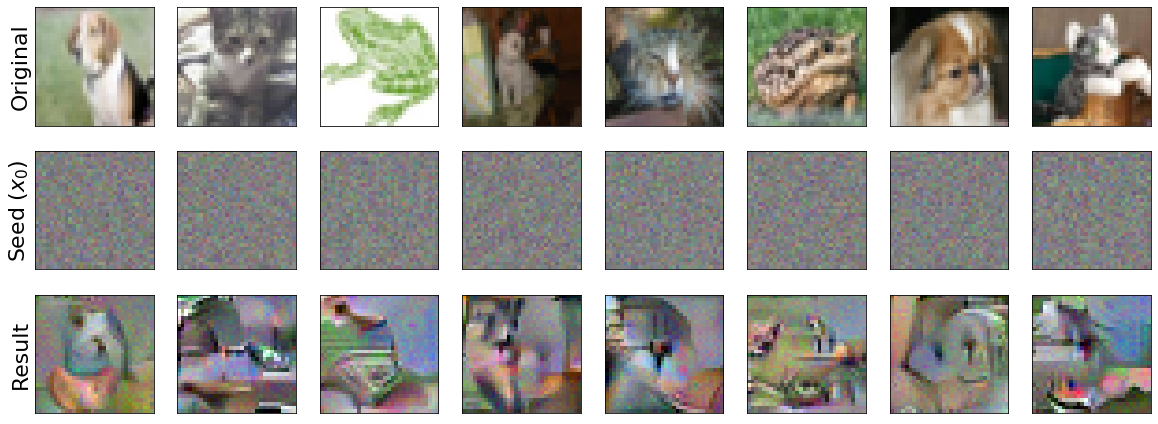

In [40]:
# Visualize inversion
show_image_row([im.cpu(), im_n.cpu(), xadv.detach().cpu()], 
               ["Original", r"Seed ($x_0$)", "Result"], 
               fontsize=22)